# Plane Detection Algorithm

## What it does

The Plane detection algorithm is designed to sort through rti data collected by Zephyr to identify planes in the data. Currently it is being designed to work in tandem with other mechanisms to automate the calibration of Zephyr.

## How it works

Before RTI data is used in detect_plane, it is first passed through reduce_xarray from the zephyr repository, which effectivly formats the data, and makes "peaks" from both planes and meteors more evident. Other methods of prep can also be used to prep data. Once passed into the detect_plane function, a CFAR algorithm is used across all range gates for each individual timestamp, and the targets are recorded. These targets are then fed into the DBSCAN clustering algorithm which is used to identify groups of target points which corelate to individual objects such as planes.

# Set up of Data before use in algorithm

In [37]:
import glob # A common system tool for finding and parsing files 
data_dir = './rti_examples' # The name of the folder with the files 

In [38]:
import pickle # For loading files

file_name = 'RTI_zephyrtx3_zephyrrx2_1678336626_15s.rti'
with open(f'{data_dir}/{file_name}', "rb") as f:
        rti_xarray = pickle.load(f)

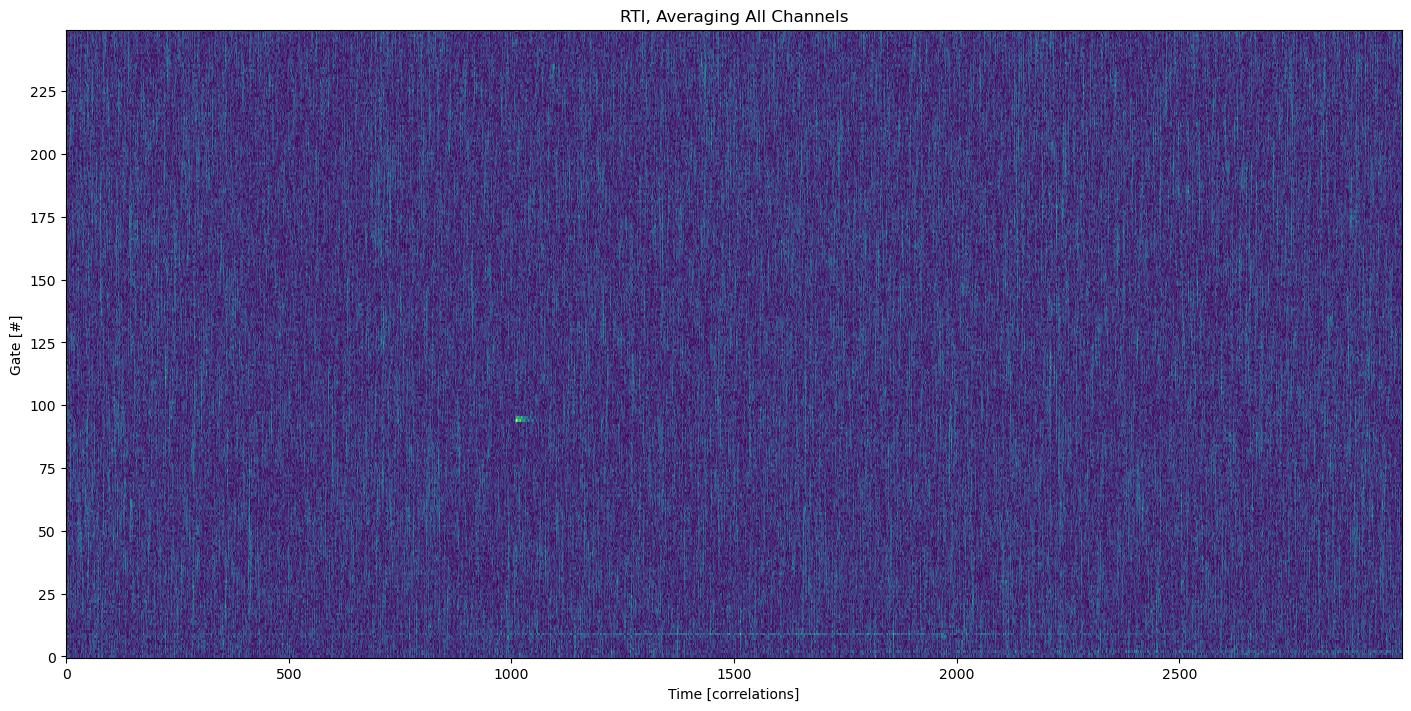

In [39]:
import numpy as np 
import matplotlib.pyplot as plt # Plotting 
from matplotlib.ticker import MaxNLocator

# RTI diagram
rti_array = rti_xarray.values[:, 0, :250, :]
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
rti_for_plot = np.abs(rti_array.mean(0))  # Collapse Doppler Dimension, mean across channels

ax.imshow(rti_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

In [40]:
def parse_selection(selection): #Other function from zephyr which I couldn't get to work.
    """
    Parse selection for slices or ranges, with support for 'all' and specific indices or ranges.

    Parameters:
    - selection: Can be 'all', a string for channel names, or a list of indices.
    """
    # If selection is "all", return a slice that selects everything
    if isinstance(selection, str) and selection == "all":
        return slice(None)  # Select all elements
    
    # If selection is a string like "120:-1", handle as a slice
    elif isinstance(selection, str) and ":" in selection:
        try:
            return slice(*map(lambda x: int(x) if x.strip() else None, selection.split(":")))
        except ValueError as e:
            raise ValueError(f"Invalid slice string: '{selection}'. Error: {e}")
    
    # If selection is a list or array of values, return it as-is
    elif isinstance(selection, (list, np.ndarray)):
        return selection
    
    else:
        raise ValueError(f"Invalid selection format: '{selection}'.")

In [41]:
def reduce_xarray(xarray_in, dim_operations, value_agg_func=np.abs): #Function from zephyr that I couldn't get to work
    """
    Reduces the RTI data based on the provided dimension operations (aggregation, selection).
    
    Parameters:
    - dim_operations (dict): Specifies "agg_func" and "selection" for each dimension.
        dim_operations = {
            "tx_rx_channel_pair": {"agg_func": None, "selection": "all"},  # Select polarimetric channels
            "doppler_hz": {"agg_func": None, "selection": [0]},  # Slice specific range
            "gate": {"agg_func": None, "selection": "all"},  # No aggregation
            "time": {"agg_func": None, "selection": "all"}  # Median over specific time slice
            }
    - value_agg_func (callable): Function to transform the data (e.g., np.abs, np.angle).
    
    Returns:
    - reduced_data (numpy.ndarray): Reduced data (2D or 3D) ready for plotting.
    """
    xarray_out = xarray_in.copy()
    xarray_out.attrs =  xarray_in.attrs.copy()
    
    # Apply operations for each dimension
    for dim, operations in dim_operations.items():
        if dim not in xarray_out.dims:
            raise ValueError(f"Dimension '{dim}' not found in data.")

        # Apply selection
        selection = operations.get("selection", "all")
        if dim == "tx_rx_channel_pair" and selection == "polarimetric":
            polarimetric_values = xarray_out.coords['polarimetric_channel'].values
            desired_channels = polarimetric_values[polarimetric_values != None]
            mask = np.isin(polarimetric_values, desired_channels)
            xarray_out = xarray_out.sel(tx_rx_channel_pair=mask)
        else:
            parsed_selection = parse_selection(selection)
            xarray_out = xarray_out.sel({dim: parsed_selection})

        # Apply aggregation if specified
        agg_func = operations.get("agg_func", None)
        if agg_func is not None:
            if not callable(agg_func):
                raise ValueError(f"Aggregation function for '{dim}' must be callable or None.")
            xarray_out = xarray_out.reduce(agg_func, dim=dim, keep_attrs=True)

    # Apply value aggregation function (e.g., np.abs, np.angle)
    if value_agg_func is not None:
        if not callable(value_agg_func):
            raise ValueError("value_agg_func must be a callable function.")
        xarray_out = value_agg_func(xarray_out)
    
    # Modify metadata attributes
    if value_agg_func is not None:
        if 'units' in xarray_out.attrs:
            xarray_out.attrs['units'] = f'{xarray_out.attrs["units"]} ({value_agg_func.__name__})'
        else:
            xarray_out.attrs['units'] = value_agg_func.__name__

    # Return reduced data (converted to numpy array)
    return np.squeeze(xarray_out)


In [42]:
dim_operations = {
                    "tx_rx_channel_pair": {"agg_func": np.std, "selection": "all"},
                    "doppler_hz": {"agg_func": None, "selection": [0]}}
rti_for_det = reduce_xarray(rti_xarray, dim_operations, value_agg_func=np.abs) #Set up Data in the same format as in repository

# Examples of Algorithm in Use

## Example with Basic Data and basic imports

In [43]:
from Plane_Detection import *

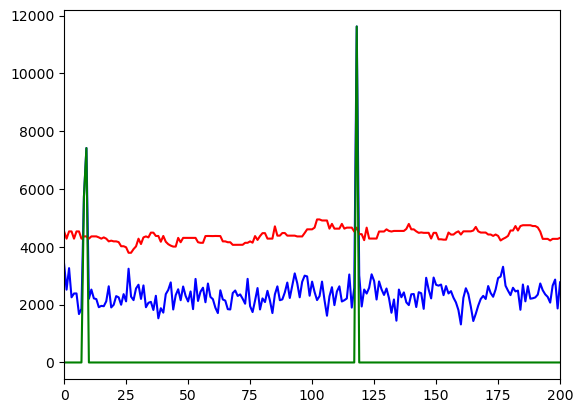

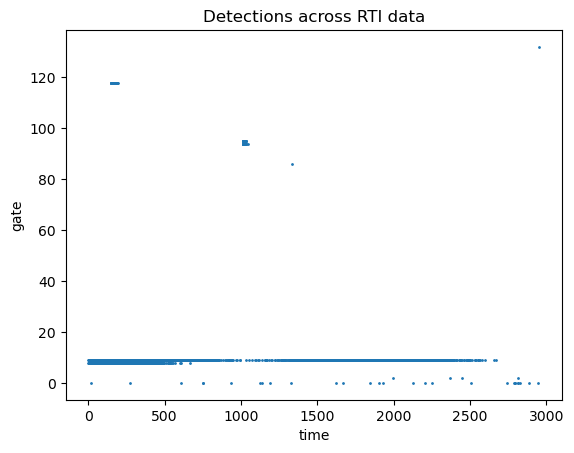

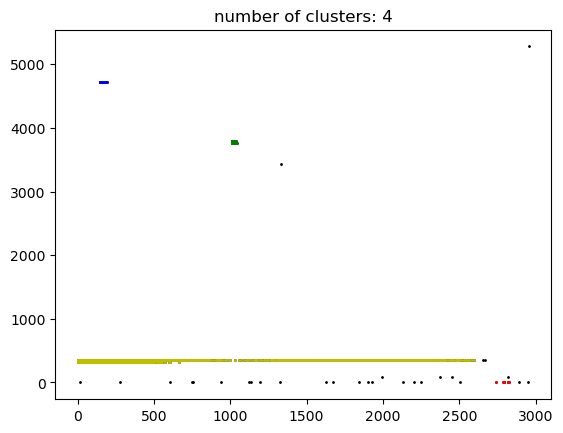

In [44]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={},optional_plots=[150,'CFAR_plot','plot_detections',"DBSCAN"])

## Function Inputs and Outputs
(Basically just copy from input/output in code, with additional explanations)
Also include default biases

## Examples of how changing different values changes detection
### Changing Bias
Default Bias: 1.9

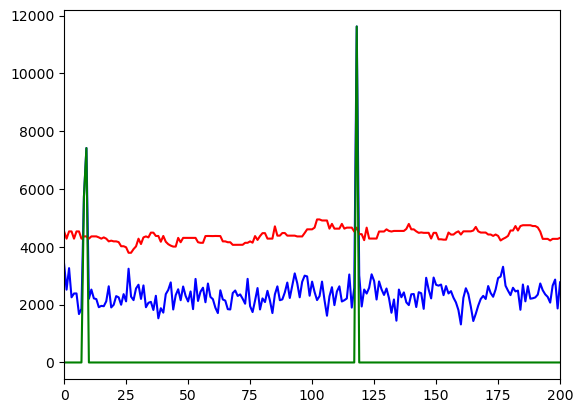

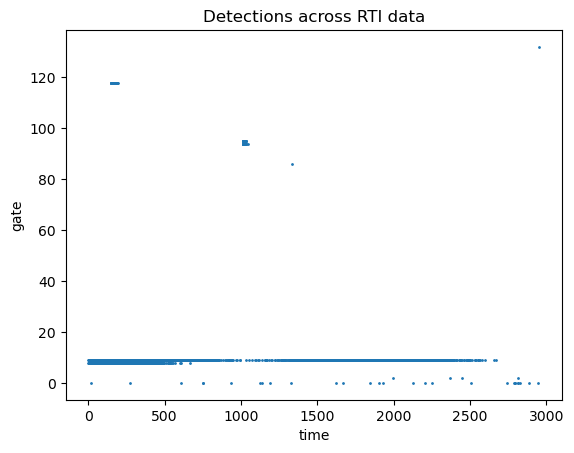

In [45]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"bias":1.9},optional_plots=[150,'CFAR_plot','plot_detections'])

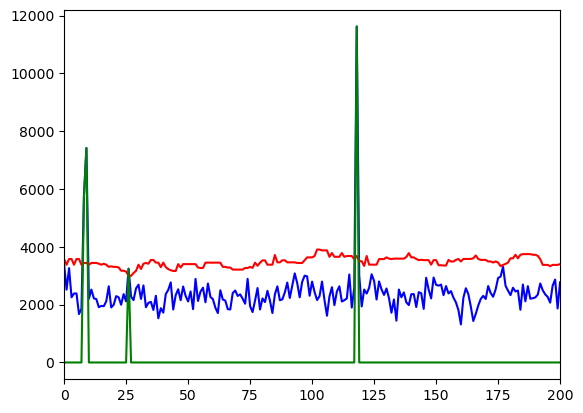

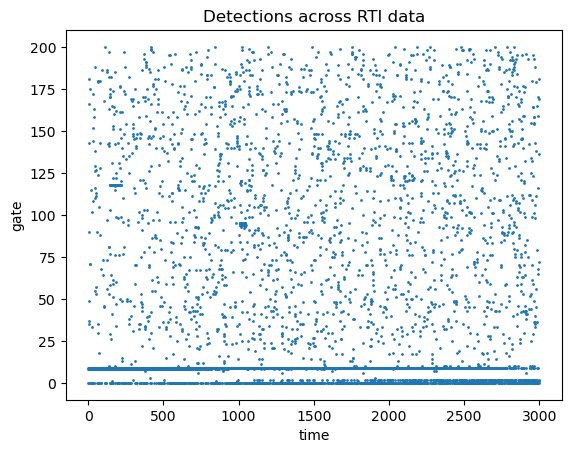

In [46]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"bias":1.5},optional_plots=[150,'CFAR_plot','plot_detections'])

### Changing the Number of Reference Cells
Default Reference cells

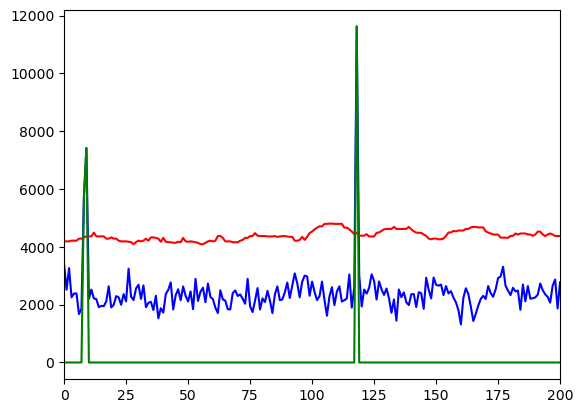

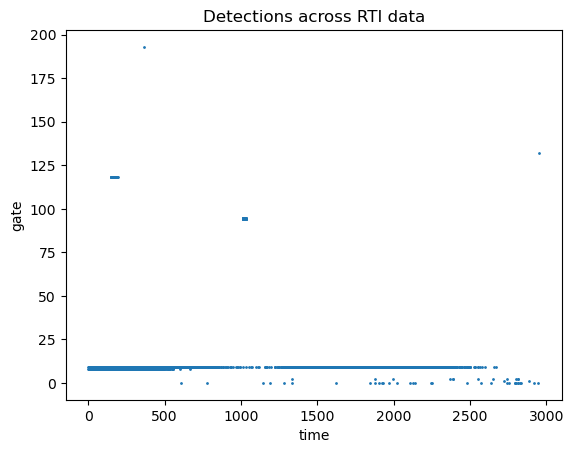

In [49]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"num_ref_cells":20},optional_plots=[150,'CFAR_plot','plot_detections'])

### method
default: np.median
(Maybe something on DBSCAN)

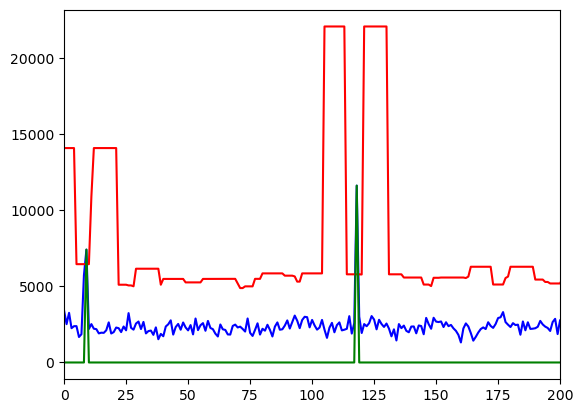

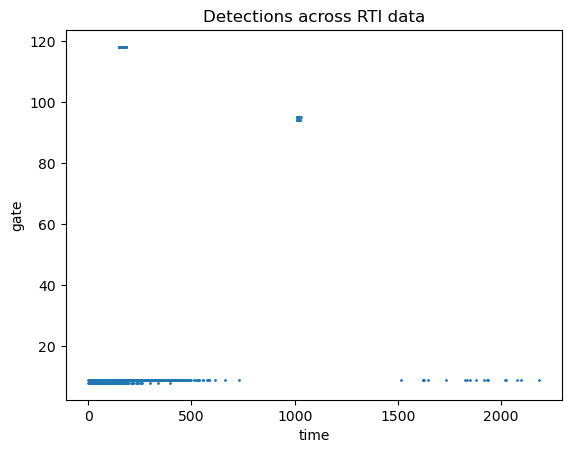

In [51]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"method":np.max},optional_plots=[150,'CFAR_plot','plot_detections'])

### Changing eps
Default: 55

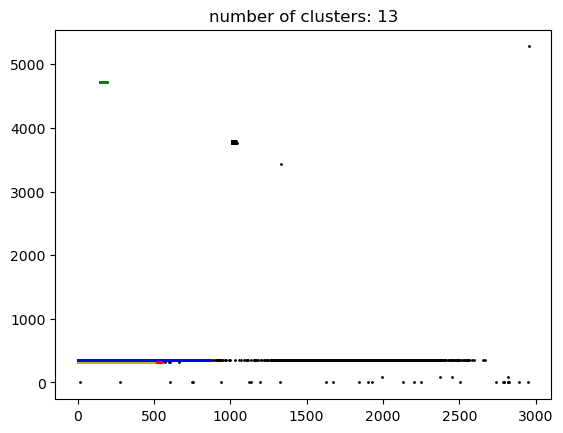

In [55]:
detections,img,list_dict_properties,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"eps":10},optional_plots=['DBSCAN'])

## Examples with different datasets
### One with "Bouncing" plane
### One with nothing in it at all (if available)
### Plane part way through

# Known issues, or inconsistancies with the algorithm

# Other Resources / other useful resources

# Further work